In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import re
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [2]:
df=pd.read_csv('fake_job_postings.csv')

In [3]:
df.head()

job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0             NaN                 NaN   
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                NaN                        NaN             Marketing   
1                NaN  Marketing and Advertising      Customer Service   
2                NaN                        NaN                   NaN   
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

In [4]:
df.shape

(17880, 18)

In [5]:
df.describe()

job_id  telecommuting  has_company_logo  has_questions  \
count  17880.000000   17880.000000      17880.000000   17880.000000   
mean    8940.500000       0.042897          0.795302       0.491723   
std     5161.655742       0.202631          0.403492       0.499945   
min        1.000000       0.000000          0.000000       0.000000   
25%     4470.750000       0.000000          1.000000       0.000000   
50%     8940.500000       0.000000          1.000000       0.000000   
75%    13410.250000       0.000000          1.000000       1.000000   
max    17880.000000       1.000000          1.000000       1.000000   

         fraudulent  
count  17880.000000  
mean       0.048434  
std        0.214688  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [7]:
fraudulent_counts=df["fraudulent"].value_counts()

In [8]:
fraudulent_counts

fraudulent
0    17014
1      866
Name: count, dtype: int64

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Fraudulent vs Non-Fraudulent Instances')

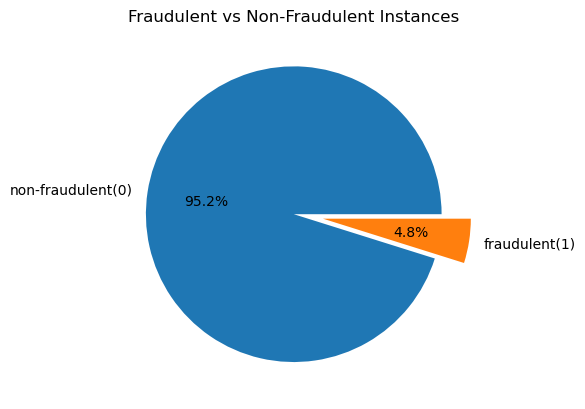

In [10]:
plt.pie(fraudulent_counts,explode=(0,0.2),labels=['non-fraudulent(0)','fraudulent(1)'],autopct='%1.1f%%')
plt.title('Fraudulent vs Non-Fraudulent Instances')

#### From the above pie chart, it is clear that there is class imbalance

In [11]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

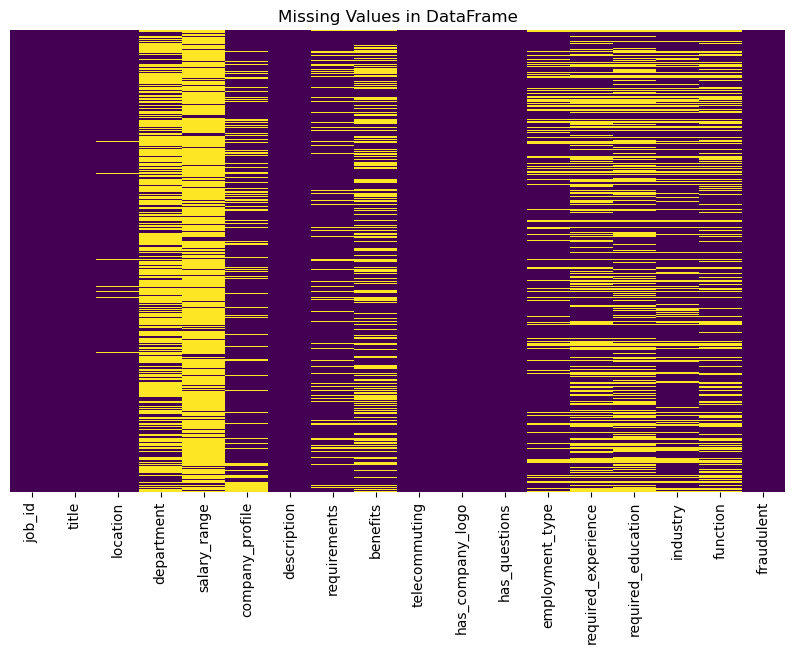

In [12]:
#Visualizing missing values by column
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values in DataFrame')
plt.show()

### We have too many null values, we need to deal with it

In [13]:
# Dropping the columns that are insignificant
columns_to_drop=['location', 'salary_range']
df.drop(columns=columns_to_drop,inplace=True)

In [14]:
df.duplicated().sum()

0

In [15]:



#drop duplicated values
df.drop_duplicates(inplace=True)

In [16]:
text_columns = df.select_dtypes(include=['object']).columns

In [17]:
text_columns

Index(['title', 'department', 'company_profile', 'description', 'requirements',
       'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function'],
      dtype='object')

In [18]:
#replace nan values in text column with space
for col in text_columns:
    df[col].fillna(' ', inplace=True)

In [19]:
df.head()

job_id                                      title department  \
0       1                           Marketing Intern  Marketing   
1       2  Customer Service - Cloud Video Production    Success   
2       3    Commissioning Machinery Assistant (CMA)              
3       4          Account Executive - Washington DC      Sales   
4       5                        Bill Review Manager              

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  telecommuting  \
0                                                                 0   
1  What you will get from usThrough being part of...              0   
2                                                                 0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2                 1              0                                       
3                 1              0       Full-time    Mid-Senior level   
4                 1              1       Full-time    Mid-Senior level   

  required_education                   industry              function  \
0                                                           Marketing   
1                     Marketing and Advertising      Customer Service   
2                                                                       
3  Bachelor's Degree          Computer Software                 Sales   
4  Bachelor's Degree     Hospital & Health Care  Health Care Provider   

   fraudulent  
0           0  
1           0  
2           0  
3           0  
4           0

#### Now we are going to create a new columns called "text" where we concatenate texts from all the above text columns 

In [20]:
df["text"]=""
for col in text_columns:
    df["text"]=df["text"]+" "+ df[col]

In [21]:
df["text"][0]

" Marketing Intern Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community and crowd-sou

In [22]:
#Now that we have all the texts from all the columns and irrelevant columns too

del df['job_id']
del df['title']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['employment_type']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']



In [23]:
df.head()

telecommuting  has_company_logo  has_questions  fraudulent  \
0              0                 1              0           0   
1              0                 1              0           0   
2              0                 1              0           0   
3              0                 1              0           0   
4              0                 1              1           0   

                                                text  
0   Marketing Intern Marketing We're Food52, and ...  
1   Customer Service - Cloud Video Production Suc...  
2   Commissioning Machinery Assistant (CMA)   Val...  
3   Account Executive - Washington DC Sales Our p...  
4   Bill Review Manager   SpotSource Solutions LL...

In [24]:
numeric_df = df.drop(columns=['text'])

<Axes: >

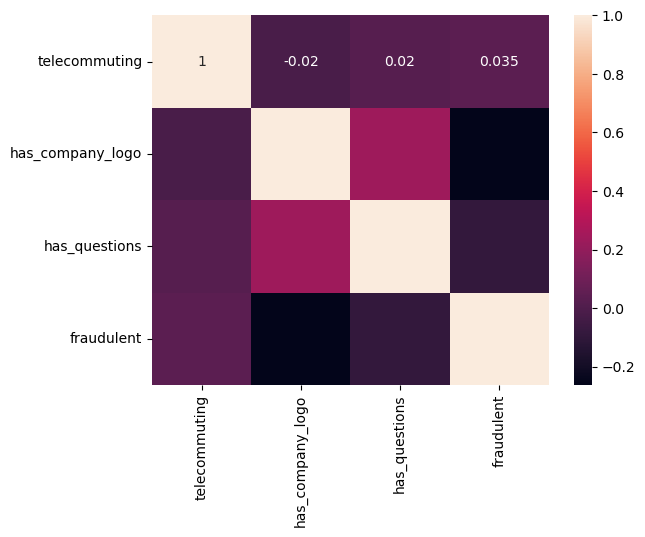

In [25]:
sns.heatmap(numeric_df.corr(),annot=True)

#### column has_company_logo is somewhat correlated to fraudulent class labels

In [26]:
df['text_length'] = df['text'].str.len()

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\admin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

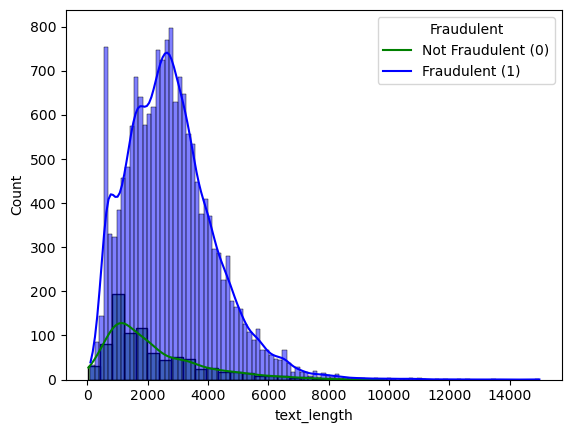

In [27]:
sns.histplot(x=df[df["fraudulent"]==1]["text_length"],kde=True,color='green')
sns.histplot(x=df[df["fraudulent"]==0]["text_length"],kde=True,color="blue");
plt.legend(title='Fraudulent', labels=['Not Fraudulent (0)', 'Fraudulent (1)'])

#### It seems that fraudulent job postings have much more texts than real jobs

In [28]:
# Now lets get on to preprocessing the text

In [29]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

def clean_text(text):
    # Lowercasing
    text = text.lower()
    
    # Tokenization
    words = word_tokenize(text)
    
    # Removing punctuation and numbers
    words = [word for word in words if word.isalpha()]
    
    # Removing special characters
    words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stemming
    porter = PorterStemmer()
    words = [porter.stem(word) for word in words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()  # Correct instantiation of WordNetLemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Joining the cleaned words back into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text


In [30]:
df['clean_text']=df['text'].apply(clean_text)

In [31]:
df['clean_text'][0]

'market intern market creat groundbreak cook site support connect celebr home cook give everyth need one top editori busi engin team focus use technolog find new better way connect peopl around specif food interest offer superb highli curat inform food cook attract talent home cook contributor countri also publish profession like mario batali gwyneth paltrow danni meyer partnership whole food market random name best food websit jame beard foundat iacp featur new york time npr pando daili techcrunch today locat chelsea new york citi jame beard onlin food commun curat recip hub current interview unpaid intern work small team editor execut develop new york citi repackag exist content number partner site huffington post yahoo buzzfe variou content manag systemsresearch blog websit provis affili programassist affili program support screen affili assist affili inquiriessupport pr amp event neededhelp offic administr work file mail prepar meetingswork develop document bug suggest improv sites

In [32]:
# Let us visualize the word clouds of tfidf and Bag of words

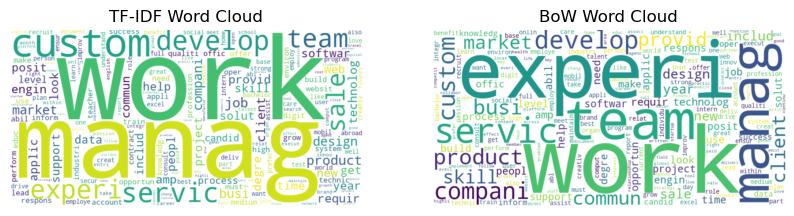

In [33]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud



# tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# Bag of words vectorizer
bow_vectorizer = CountVectorizer()
bow_matrix = bow_vectorizer.fit_transform(df['clean_text'])

# Getting vocabulaires
tfidf_vocabulary = tfidf_vectorizer.get_feature_names_out()
bow_vocabulary = bow_vectorizer.get_feature_names_out()

# Calculate word frequencies for TF-IDF and BoW
tfidf_word_frequencies = dict(zip(tfidf_vocabulary, tfidf_matrix.sum(axis=0).tolist()[0]))
bow_word_frequencies = dict(zip(bow_vocabulary, bow_matrix.sum(axis=0).tolist()[0]))

# Create word clouds for TF-IDF and BoW
tfidf_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_word_frequencies)
bow_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bow_word_frequencies)

# Plot word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tfidf_wordcloud, interpolation='bilinear')
plt.title('TF-IDF Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bow_wordcloud, interpolation='bilinear')
plt.title('BoW Word Cloud')
plt.axis('off')

plt.show()


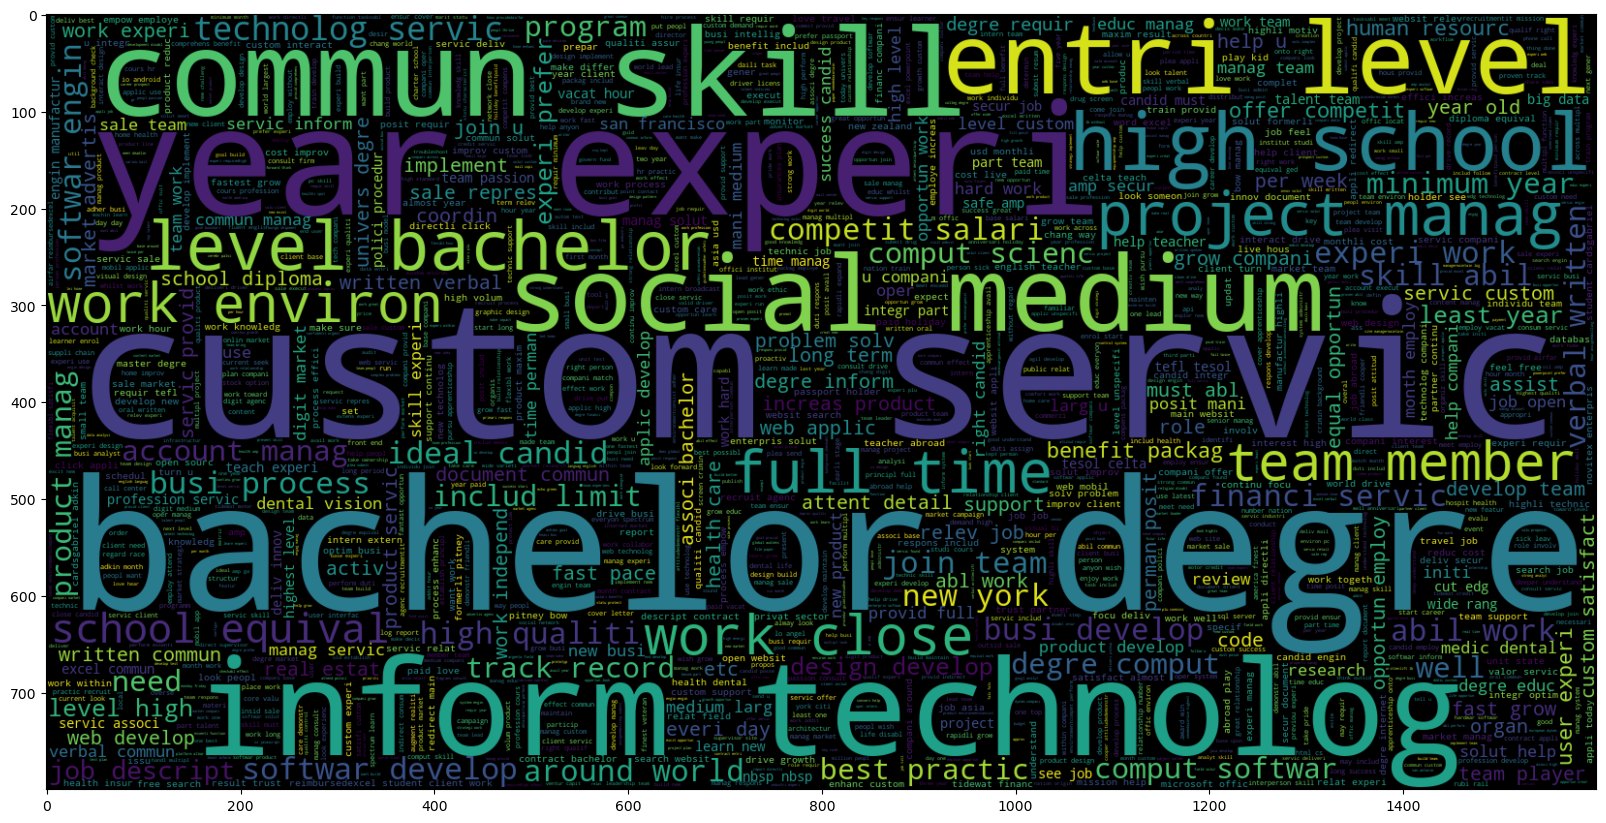

In [34]:
# wordcloud for legit job postings
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 0].clean_text))
plt.imshow(wc , interpolation = 'bilinear')



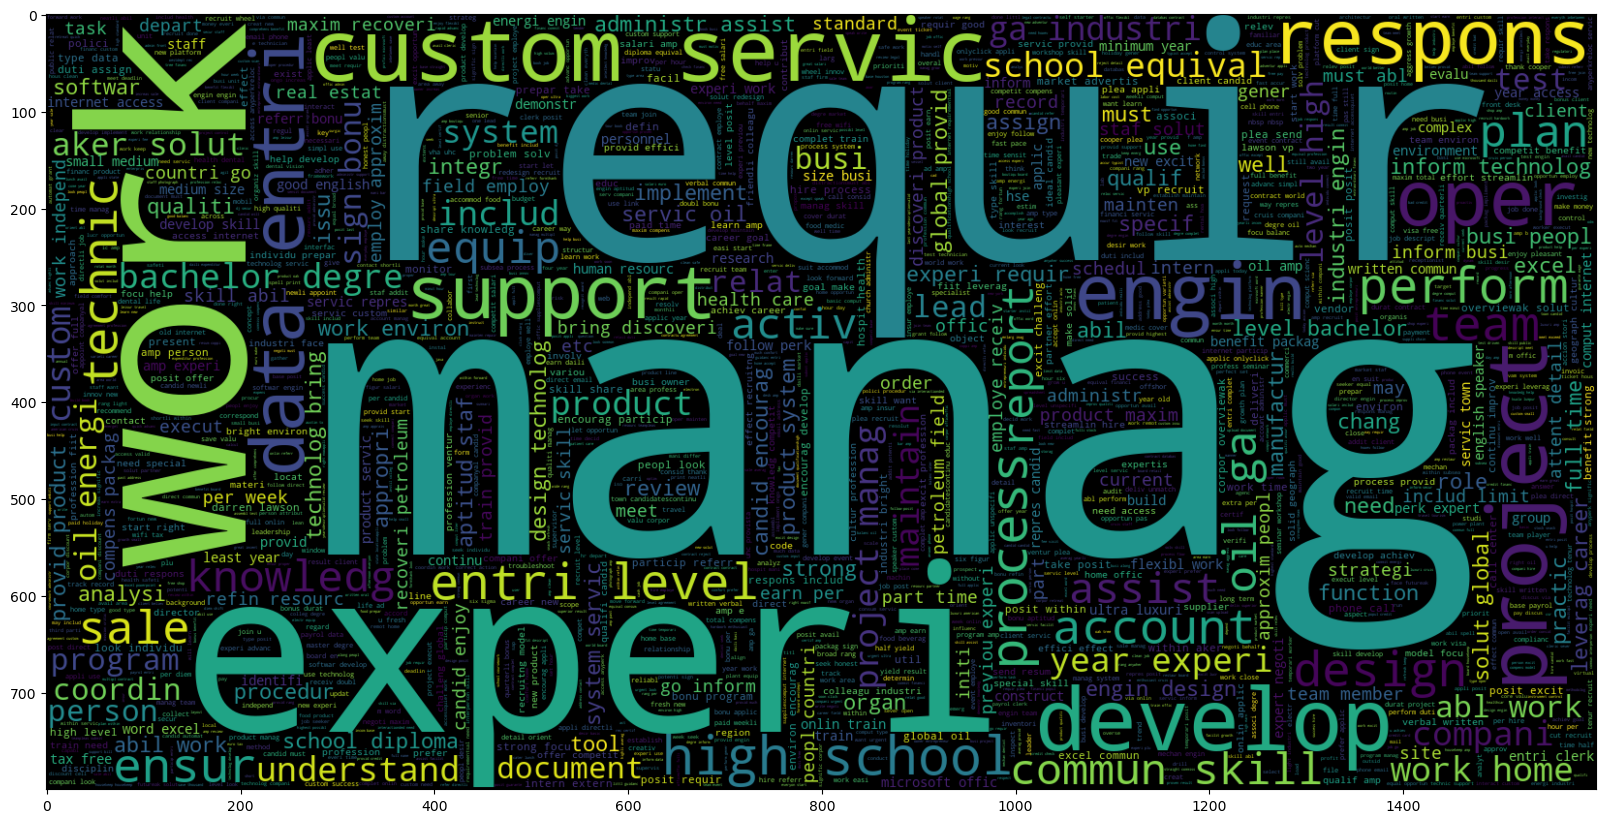

In [35]:
# wordcloud for fraudulent job postings
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.fraudulent == 1].clean_text))
plt.imshow(wc , interpolation = 'bilinear')

## Regression Model Building

In [36]:
df

telecommuting  has_company_logo  has_questions  fraudulent  \
0                  0                 1              0           0   
1                  0                 1              0           0   
2                  0                 1              0           0   
3                  0                 1              0           0   
4                  0                 1              1           0   
...              ...               ...            ...         ...   
17875              0                 1              1           0   
17876              0                 1              1           0   
17877              0                 0              0           0   
17878              0                 0              1           0   
17879              0                 1              1           0   

                                                    text  text_length  \
0       Marketing Intern Marketing We're Food52, and ...         2705   
1       Customer Service - Cloud Video Production Suc...         6212   
2       Commissioning Machinery Assistant (CMA)   Val...         2654   
3       Account Executive - Washington DC Sales Our p...         5538   
4       Bill Review Manager   SpotSource Solutions LL...         4041   
...                                                  ...          ...   
17875   Account Director - Distribution  Sales Vend i...         5376   
17876   Payroll Accountant Accounting WebLinc is the ...         4826   
17877   Project Cost Control Staff Engineer - Cost Co...         2839   
17878   Graphic Designer     Nemsia Studios is lookin...         1307   
17879   Web Application Developers Engineering Vend i...         4676   

                                              clean_text  
0      market intern market creat groundbreak cook si...  
1      custom servic cloud video product success seco...  
2      commiss machineri assist cma valor servic prov...  
3      account execut washington dc sale passion impr...  
4      bill review manag spotsourc solut llc global h...  
...                                                  ...  
17875  account director distribut sale vend look awes...  
17876  payrol account account weblinc platform servic...  
17877  project cost control staff engin cost control ...  
17878  graphic design nemsia studio look experienc de...  
17879  web applic develop engin vend look awesom new ...  

[17880 rows x 7 columns]

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['fraudulent'], test_size=0.2, random_state=42)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# TF-IDF X_train
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# TF-IDF X_test
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize Bag-of-Words (BoW) vectorizer
bow_vectorizer = CountVectorizer()

# BoW X_train
X_train_bow = bow_vectorizer.fit_transform(X_train)

# BoW X_test
X_test_bow = bow_vectorizer.transform(X_test)

# Initializing regressor
regressor = LinearRegression()

# Training for TF-IDF
regressor.fit(X_train_tfidf, y_train)

# Making predictions for TF-IDF
y_pred_tfidf = regressor.predict(X_test_tfidf)

# MSE for TF-IDF
mse_tfidf = mean_squared_error(y_test, y_pred_tfidf)
print("Mean Squared Error (TF-IDF):", mse_tfidf)

# Training for BoW
regressor.fit(X_train_bow, y_train)

# Making predictions for BoW
y_pred_bow = regressor.predict(X_test_bow)

# MSE for BoW
mse_bow = mean_squared_error(y_test, y_pred_bow)
print("Mean Squared Error (BoW):", mse_bow)


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

Mean Squared Error (TF-IDF): 0.038506076461741014
Mean Squared Error (BoW): 0.2559567584829901


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


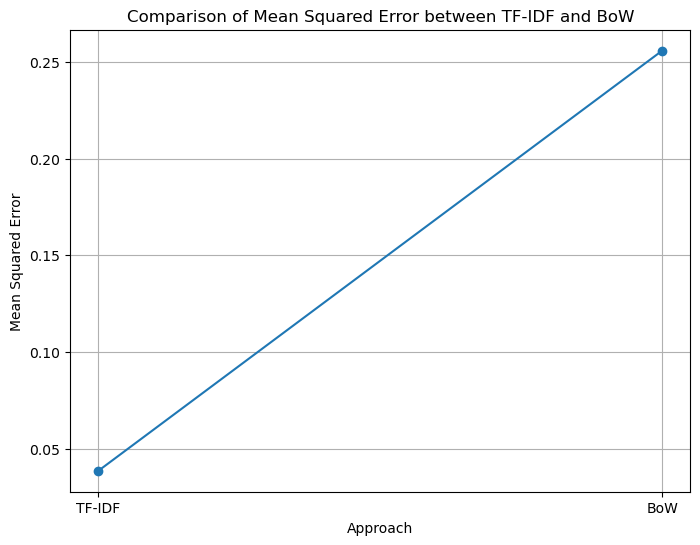

In [39]:
# Create line plot
approaches = ['TF-IDF', 'BoW']
mse_values = [mse_tfidf, mse_bow]
plt.figure(figsize=(8, 6))
plt.plot(approaches, mse_values, marker='o', linestyle='-')
plt.xlabel('Approach')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Mean Squared Error between TF-IDF and BoW')
plt.grid(True)
plt.show()


#### So, for regression, tf-idf vectorizer performed significantly better than BoW vectorizer.

# Building Classifier Model

In [40]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Train Test split
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['fraudulent'], test_size=0.2, random_state=42)



# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier using TF-IDF 
rf_classifier.fit(X_train_tfidf, y_train)

# Predict on the test data using TF-IDF 
y_pred_tfidf = rf_classifier.predict(X_test_tfidf)

# Evaluate TF-IDF
print("Classification Report (TF-IDF Representation):\n", classification_report(y_test, y_pred_tfidf))
print("Accuracy for TF-IDF: ",accuracy_score(y_test,y_pred_tfidf))

# Train the classifier using BoW 
rf_classifier.fit(X_train_bow, y_train)

# Predict on the test data using BoW 
y_pred_bow = rf_classifier.predict(X_test_bow)

# Evaluate BoW
print("Classification Report (BoW Representation):\n", classification_report(y_test, y_pred_bow))
print("Accuracy for Bag of Words: ",accuracy_score(y_test,y_pred_bow))


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

Classification Report (TF-IDF Representation):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.59      0.74       181

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576

Accuracy for TF-IDF:  0.9793064876957495
Classification Report (BoW Representation):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3395
           1       1.00      0.59      0.74       181

    accuracy                           0.98      3576
   macro avg       0.99      0.80      0.87      3576
weighted avg       0.98      0.98      0.98      3576

Accuracy for Bag of Words:  0.9793064876957495


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

## For classifier both tf-idf and BoW produced similar accuracies. However recall values are low for both

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

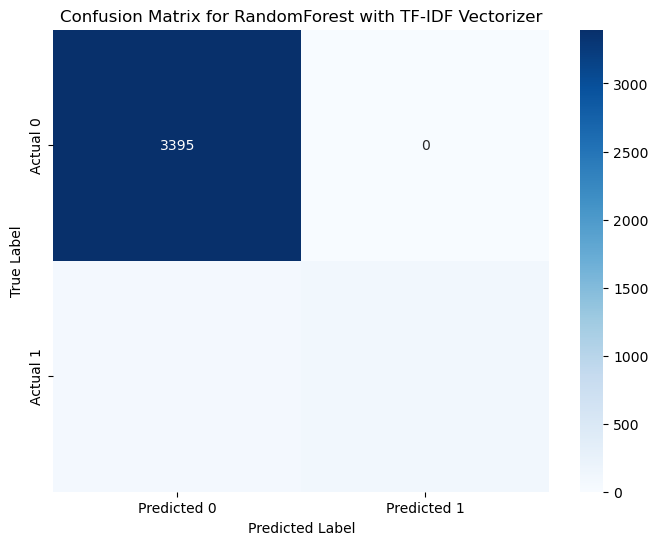

In [41]:
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RandomForest with TF-IDF Vectorizer')
plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

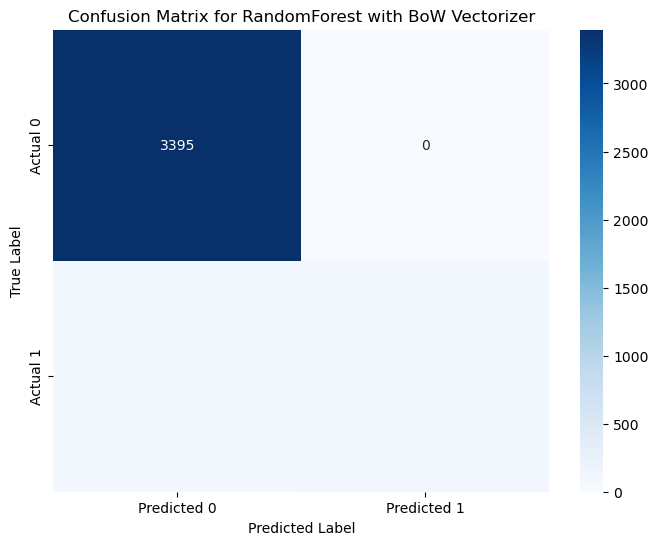

In [42]:
cm_BoW = confusion_matrix(y_test, y_pred_bow)

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_BoW, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RandomForest with BoW Vectorizer')
plt.show()